In [49]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',500)


In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



In [ ]:
df_properties=pd.read_excel('../data/CACODE_properties.xlsx')


In [79]:
df2201_sale2 = pd.read_pickle('../data/df2201_sale2.pickle')
df2201_rent2 = pd.read_pickle('../data/df2201_rent.pickle')

df2201_sale2.head(1)

,use_sf,build_sf,price,area,title,estate,floor,floor_flg,lat,long,CACODE
0,1240.0,NaN,340000000.0,大嶼山,澄碧邨 9座 2樓 A室,澄碧邨,室,L,22.214953,113.989682,T01


In [80]:
df2201_rent2.head(1)

,use_sf,build_sf,price,area,title,addr_home,floor,floor_flg,lat,long,CACODE
0,1216.0,1579.0,67500.0,西半山,杏彤苑 中層 B室,"['Hatton Place, 1A Po Shan Rd, Mid-Levels, Hong Kong']",中,M,22.279991,114.13896,A05


categorical features: CACODE, floor_flg, estate </br>
numerical features: use_sf, rent_per_sqft/sale_per_sqft

In [81]:
df2201_rent2['estate'] = df2201_rent2["title"].str.split(" ").str.get(0)
df2201_rent2['rent_per_sqft'] = df2201_rent2['price'].fillna(0)/df2201_rent2['use_sf'].fillna(0)
df2201_rent2["rent_per_sqft"] = df2201_rent2["rent_per_sqft"].replace([np.inf, -np.inf], np.nan)
df2201_rent2 = df2201_rent2.fillna(0)

df2201_sale2['sale_per_sqft'] = df2201_sale2['price'].fillna(0)/df2201_sale2['use_sf'].fillna(0)
df2201_sale2['sale_per_sqft'] = df2201_sale2['sale_per_sqft'].replace([np.inf, -np.inf], np.nan)
df2201_sale2 = df2201_sale2.fillna(0)



In [82]:
# One-hot encode the categorical feature
encoder = OneHotEncoder()
category_encoded = encoder.fit_transform(df2201_rent2[["CACODE","floor_flg","estate"]])
category_df = pd.DataFrame(category_encoded.toarray(), columns=encoder.get_feature_names_out(["CACODE","floor_flg","estate"]))

# Scale the numerical feature
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df2201_rent2[["use_sf","rent_per_sqft"]])
numeric_df = pd.DataFrame(numeric_scaled, columns=["use_sf","rent_per_sqft"])


# Concatenate the one-hot encoded and scaled features into a single DataFrame
features_df = pd.concat([category_df, numeric_df], axis=1)

features_df = features_df.fillna(0)


C:\Users\1\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\1\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\1\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\1\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_

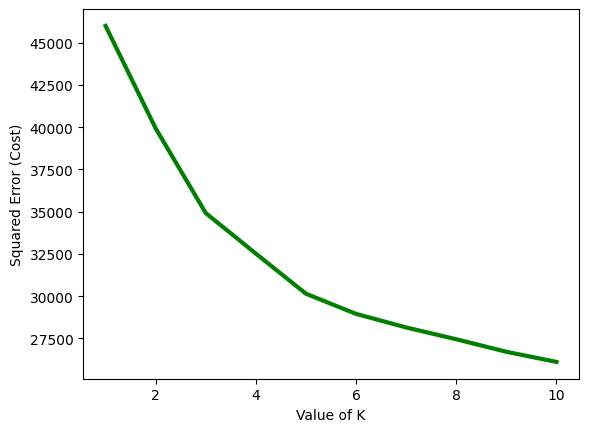

In [83]:
cost =[]
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(features_df)
     
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)    
 
# plot the cost against K values
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot
 
# the point of the elbow is the
# most optimal value for choosing k

build a pipeline

In [91]:
# Define the transformers for each feature type
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Define the column transformer to apply the transformers to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["use_sf","rent_per_sqft"]),
        ("cat", categorical_transformer, ["CACODE","floor_flg","estate"])
    ])

kmeans = KMeans(n_clusters=6,random_state=12345)

# Define the pipeline to preprocess the data and perform clustering
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("kmeans", kmeans)
])

# Fit the pipeline to the data
pipeline.fit(df2201_rent2)

C:\Users\1\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['use_sf', 'rent_per_sqft']),
                                                 ('cat', OneHotEncoder(),
                                                  ['CACODE', 'floor_flg',
                                                   'estate'])])),
                ('kmeans', KMeans(n_clusters=6, random_state=12345))])

In [92]:
# len(kmeans.labels_)
df2201_rent2['kMeans_label'] = kmeans.labels_
df2201_rent2_ = pd.merge(df2201_rent2,df_properties,how='left',on='CACODE')
# df2201_rent2_.ENAME.nunique()
# df2201_rent2_.sample(1)
cluster_num_feature = pd.pivot_table(df2201_rent2_, 
               values=["use_sf","rent_per_sqft"], 
               index=["kMeans_label"], 
               aggfunc={"use_sf":"median","rent_per_sqft":"median"}).reset_index()
cluster_cat_feature1 = pd.pivot_table(df2201_rent2_, 
               values=["title"], 
               columns=['DISTRICT_E'],
               index=["kMeans_label"], 
               aggfunc={"title":"count"}).reset_index()
cluster_cat_feature2 = pd.pivot_table(df2201_rent2_, 
               values=["title"], 
               columns=['floor_flg'],
               index=["kMeans_label"], 
               aggfunc={"title":"count"}).reset_index()
cluster_profile = pd.concat([cluster_num_feature,cluster_cat_feature2,cluster_cat_feature1], axis=1)
cluster_profile

,kMeans_label,rent_per_sqft,use_sf,"(kMeans_label, )","(title, H)","(title, L)","(title, M)","(kMeans_label, )","(title, Central & Western District)","(title, Eastern District)","(title, Islands District)","(title, Kowloon City District)","(title, Kwai Tsing District)","(title, Kwun Tong District)","(title, North District)","(title, Sai Kung District)","(title, Sha Tin District)","(title, Sham Shui Po District)","(title, Southern District)","(title, Tai Po District)","(title, Tsuen Wan District)","(title, Tuen Mun District)","(title, Wan Chai District)","(title, Wong Tai Sin District)","(title, Yau Tsim Mong District)","(title, Yuen Long District)"
0,0,44.740024,970.0,0,279.0,263.0,298.0,0,156.0,116.0,7.0,69.0,NaN,3.0,1.0,23.0,21.0,33.0,87.0,18.0,8.0,6.0,71.0,11.0,159.0,4.0
1,1,33.057851,517.0,1,NaN,NaN,2527.0,1,30.0,148.0,176.0,126.0,82.0,55.0,108.0,414.0,257.0,100.0,57.0,110.0,157.0,175.0,28.0,31.0,91.0,230.0
2,2,50.385811,338.0,2,568.0,449.0,551.0,2,362.0,113.0,NaN,108.0,10.0,22.0,NaN,29.0,129.0,184.0,19.0,16.0,28.0,17.0,248.0,2.0,152.0,51.0
3,3,35.315194,1732.0,3,49.0,69.0,160.0,3,42.0,2.0,9.0,28.0,NaN,1.0,6.0,6.0,37.0,8.0,40.0,40.0,1.0,3.0,22.0,3.0,2.0,10.0
4,4,33.037681,504.0,4,NaN,2294.0,NaN,4,38.0,154.0,168.0,124.0,77.0,96.0,101.0,361.0,214.0,82.0,50.0,103.0,151.0,159.0,22.0,25.0,81.0,208.0
5,5,33.530572,508.0,5,2383.0,NaN,NaN,5,14.0,152.0,153.0,121.0,94.0,82.0,91.0,371.0,228.0,102.0,44.0,129.0,159.0,162.0,33.0,29.0,94.0,248.0


In [96]:
cluster_profile.to_excel('../analysis/cluster_profile.xlsx',index=False)

cluster new data

In [94]:
sample_rent_2307=pd.read_excel('../data/sample_rent_2307.xlsx')
sample_rent_2307 = sample_rent_2307.fillna(0)
sample_rent_2307['title'] = sample_rent_2307['line1']
sample_rent_2307.head(1)



,use_sf,price,line1,estate,building,floor_flg,lat,long,CACODE,rent_per_sqft,title
0,431,17500,百合苑 中層 A室,百合苑,百合苑,M,22.283675,114.146049,A13,40.603248,百合苑 中層 A室


In [95]:
pipeline.fit(sample_rent_2307)
# len(kmeans.labels_)
sample_rent_2307['kMeans_label'] = kmeans.labels_
sample_rent_2307_ = pd.merge(sample_rent_2307,df_properties,how='left',on='CACODE')
# df2201_rent2_.ENAME.nunique()
# df2201_rent2_.sample(1)
cluster_num_feature = pd.pivot_table(sample_rent_2307_, 
               values=["use_sf","rent_per_sqft"], 
               index=["kMeans_label"], 
               aggfunc={"use_sf":"median","rent_per_sqft":"median"}).reset_index()
cluster_cat_feature1 = pd.pivot_table(sample_rent_2307_, 
               values=["title"], 
               columns=['DISTRICT_E'],
               index=["kMeans_label"], 
               aggfunc={"title":"count"}).reset_index()
cluster_cat_feature2 = pd.pivot_table(sample_rent_2307_, 
               values=["title"], 
               columns=['floor_flg'],
               index=["kMeans_label"], 
               aggfunc={"title":"count"}).reset_index()
cluster_profile_new = pd.concat([cluster_num_feature,cluster_cat_feature2,cluster_cat_feature1], axis=1)
cluster_profile_new


C:\Users\1\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,kMeans_label,rent_per_sqft,use_sf,"(kMeans_label, )","(title, H)","(title, L)","(title, M)","(kMeans_label, )","(title, Central & Western District)","(title, Sai Kung District)","(title, Sha Tin District)","(title, Southern District)","(title, Tai Po District)","(title, Tuen Mun District)"
0,0,40.420740,465.5,0,NaN,2.0,NaN,0,1.0,NaN,1.0,NaN,NaN,NaN
1,1,29.024943,739.0,1,2.0,1.0,NaN,1,NaN,NaN,1.0,NaN,NaN,2.0
2,2,54.933571,495.0,2,NaN,NaN,2.0,2,NaN,1.0,NaN,1.0,NaN,NaN
3,3,36.853002,483.0,3,NaN,NaN,3.0,3,1.0,NaN,NaN,1.0,NaN,1.0
4,4,42.143244,324.0,4,2.0,NaN,NaN,4,NaN,1.0,1.0,NaN,NaN,NaN
5,5,33.023256,1720.0,5,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,1.0,NaN
